# Toronto Neighborhood Changes Case Study Using 'tscluster'

This tutorial notebook demonstrates the detailed process of the Toronto neighborhoods changes case study using Sequence Label Analysis (SLA) and Bounded Dynamic Clustering (BDC) in 'tscluster'.

The dataset in this case study has $F=4$ socioeconomic indicators over $T=6$ timestamps from 1996 to 2021. This temporal data comes from the `Census of Canada' data provided by Statistics Canada via CHASS Data Centre. The geographic unit for this analysis was the Forward Sortation Area (FSA), with all $N = 96$ entities transformed using Z-score normalization across each timestamp per feature.

The objective of this case study is identifing different types of FSAs in Toronto by clustering their historical temporal data, and second, examined atypical FSAs that do not neatly fit into a single type, quantified by the frequency of label changes within each FSA.

We identified four different types of FSA in Toronto and captured the FSA that exhibits the most divergent transition from one neighbourhood type to another (i.e. the most frequent changes in its cluster label).

**Note: Due to the dataset size of this case study, this notebook requires a valid license from Gurobi to run the clustering algorithms. Gurobi offers a free academic license for academic users. For more information about Gurobi licenses, please refer to the website [here](https://www.gurobi.com/academia/academic-program-and-licenses/).**


In [ ]:
# download and install 'tscluster' via pip
#!pip install tscluster

#import the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from typing import List, Tuple

## Pre-processing

### Dataset description
The temporal data used in this case study is sourced from the 'Census of Canada' data provided by Statistics Canada through the CHASS Data Centre (https://datacentre.chass.utoronto.ca/).

The geographic unit for this analysis was the Forward Sortation Area (FSA), encompassing all $N = 96$ entities.

There are $F = 4$ features observed across $T = 6$ years spanning from 1996 to 2021. Below is a brief description of each feature and their respective names that will be used in this notebook:

- **Population Density**: The population density of each FSA, obtained from the total population divided by the area of each FSA from the shapefile.
- **Median Total Income**: Median income among recipients aged 15 years and over.
- **Young Population**: Percentage of the young (aged 20 - 34) population in the total popluation of each FSA.
- **Visible Minority**: Percentage of the visible minority population based on the Statistics Canada’s definition of visible minority.

For more detailed information about how these features were derived, please refer to the original paper.

In [ ]:
# Download the dervied temporal data and load it into a pandas dataframe
# (also available in the test/toronto_fsa folder of the 'tscluster' github repo)
temporal_data = pd.read_csv('toronto_census_data_by_fsa.csv')
# Display the first few rows of the data
temporal_data.head()

,year,FSA,Population Density,Visible Minority,Median Total Income,Young Population
0,1996,M1B,0.001630,0.719880,20097.0,0.246507
1,1996,M1C,0.002145,0.338884,26935.0,0.207376
2,1996,M1E,0.002931,0.367302,19992.0,0.226050
3,1996,M1G,0.003215,0.514389,16749.0,0.242840
4,1996,M1H,0.003692,0.484527,18399.0,0.250900


The example above displays data for 5 entities (i.e. FSA) with the values of each studied feature in the year 1996. The FSA code for each entity is labeled in the column 'FSA', and the year is indicated in the 'year' column.

In [ ]:
print('unique year:', temporal_data['year'].unique())
print('number of unique fsa:', len(temporal_data['FSA'].unique()))

unique year: [1996 2001 2006 2011 2016 2021]
number of unique fsa: 96


There are $T = 6$ timestamps and $N = 96$ FSA entities in this temporal dataset.

### Missing value

In [ ]:
#replace 0 with nan
temporal_data.replace(0,np.nan,inplace=True)
#check for missing values
temporal_data.isnull().sum()

year                    0
FSA                     0
Population Density     96
Visible Minority        0
Median Total Income     1
Young Population        0
dtype: int64

There are 96 missing timestamps in the feature 'Population Density' and 1 missing timestamp in the feature 'Young Population'. We used linear interplation to impute these missing value.

In [ ]:
#arrange by fsa and year
temporal_data.sort_values(by=['FSA','year'],inplace=True)
temporal_data.reset_index(drop=True,inplace=True)

#select fsa that exist in all years
common_fsa = temporal_data[temporal_data['year'].isin([1996])]['FSA'].tolist()

for fsa in common_fsa:
    #select the current fsa
    current_fsa = temporal_data[temporal_data['FSA'].isin([fsa])]
    for feature in current_fsa.columns:
        if feature not in ['FSA','year']:
            #interpolate missing values
            current_fsa.loc[:,feature] = current_fsa.loc[:,feature].interpolate(method='linear')
            #fill missing values at the beginning of the series (using the first valid value)
            current_fsa.loc[:,feature] = current_fsa.loc[:,feature].bfill()
    #update the temporal data
    temporal_data.update(current_fsa)

In [ ]:
# check for missing values after interpolation
temporal_data.isnull().sum()

year                   0
FSA                    0
Population Density     0
Visible Minority       0
Median Total Income    0
Young Population       0
dtype: int64

### Z-score Normalization

Note that different features are in different scales and units. For example, 'Total Median Income' is recorded in Canadian Dollars, while 'Young Population' is a percentage. Therefore, we utilize Z-score normalization per timestamp $T$ per feature $F$ to ensure that all features are on the same scale and to eliminate the increasing trends caused by external factors (e.g., inflation affecting 'Total Median Income').

Z-score normalization can be performed manually by users or using available pre-processing tools in 'tscluster'. In this exercise, we will demonstrate the second approach.

#### Loading Data into 'tscluster'

'tscluster' accepts several formats of temporal datasets. Please refer to the documentation for all available formats.

One of the acceptable formats is the path of a directory containing $T$ Pandas DataFrames, where each DataFrame represents one timestamp in the temporal dataset. We have broken down the temporal data from the previous section into $T = 6$ individual DataFrames and stored them in a directory named 'toronto_fsa_by_year'.

In [ ]:
#create a folder to save the data
folder = 'toronto_fsa_by_year'
#check if the folder exists
if not os.path.exists(folder):
    #if not, create the folder
    os.makedirs(folder)

#save the data by year
for year in temporal_data['year'].unique():
    #select the current year
    current_year = temporal_data[temporal_data['year'].isin([year])].copy()
    #sort by fsa to ensure the order is consistent
    current_year = current_year.sort_values(by='FSA')
    #set the index to the FSA
    current_year.index = current_year['FSA'].to_list()
    current_year.drop(columns=['FSA','year'],inplace=True)
    #save the current year into a csv file with name timestep_year.csv with the FSA as the index
    current_year.to_csv(os.path.join(folder,'timestep_'+str(year)+'.csv'), index = True)

We loaded the saved DataFrame using the `load_data` function in 'tscluster'. The `load_data` function contains two outputs:
- (1) a 3-D numpy array with dimension $(T,N,F)$ (i.e. (Number of year, Number of FSAs, Number of features))
- (2) a Python `dictionary` that contains labels of timestamps (with key `T`), entities (with key `N`) and features (with key `F`)

In [ ]:
from tscluster.preprocessing.utils import load_data
# load the data using the directory where the data is saved
# (use_suffix_as_label=True ensures that the suffix of the file is used as the label of entites and features)
# index_col=[0] ensures that the first column is used as the label for each entity
# header=0 ensures that the first row is used as the label for each feature
temporal_data, label_dict = load_data('./toronto_fsa_by_year', use_suffix_as_label=True,
                              read_file_args={'index_col': [0], 'header': 0})
# the 3-D numpy array temporal_data contains the data with shape (n_features, n_samples, n_timesteps)
print(f"shape of temporal_data is {temporal_data.shape}")

shape of temporal_data is (6, 96, 4)


 the `label_dict` contains the labels for the timestamps, entities and features from the Pandas DataFrame

In [ ]:
# first 5 entities of each label
label_dict['T'][:5], label_dict['N'][:5], label_dict['F'][:5]

(['1996', '2001', '2006', '2011', '2016'],
 ['M1B', 'M1C', 'M1E', 'M1G', 'M1H'],
 ['Population Density',
  'Visible Minority',
  'Median Total Income',
  'Young Population'])

As shown above, there are $T = 6$ years $N = 96$ FSAs and $F=4$ features in the loaded data array.

#### Z-score normalization using 'tscluster'

In [ ]:
# loaded the z-score standard scaler from tscluster
from tscluster.preprocessing import TSStandardScaler

scaler = TSStandardScaler(per_time=True) # initialize a time series standard scaler
scaler.fit(temporal_data) # fit
temporal_data_scaled = scaler.fit_transform(temporal_data) # transform
print(f"temporal_data_scaled shape is {temporal_data_scaled.shape}")
print()
print("The value of four features of the first five FSAs in 1996 are:")
print(temporal_data_scaled[0, :5, :])


temporal_data_scaled shape is (6, 96, 4)

The value of four features of the first five FSAs in 1996 are:
[[-0.97548338  2.19399549 -0.32845476 -0.2820364 ]
 [-0.82692074  0.03330543  0.63842612 -0.82223389]
 [-0.60021924  0.19446558 -0.34330157 -0.56444238]
 [-0.51810172  1.02862245 -0.80185592 -0.33266133]
 [-0.38065401  0.8592721  -0.56854889 -0.22139573]]


### Visualizing the temporal dataset
After normalizing the data, we visualized the temporal data using the `tsplot` module in 'tscluster'. The output of the `tsplot.plot()` function will be a group of time series plots, each visualizing entities' time series for one of the four features in the temporal dataset.

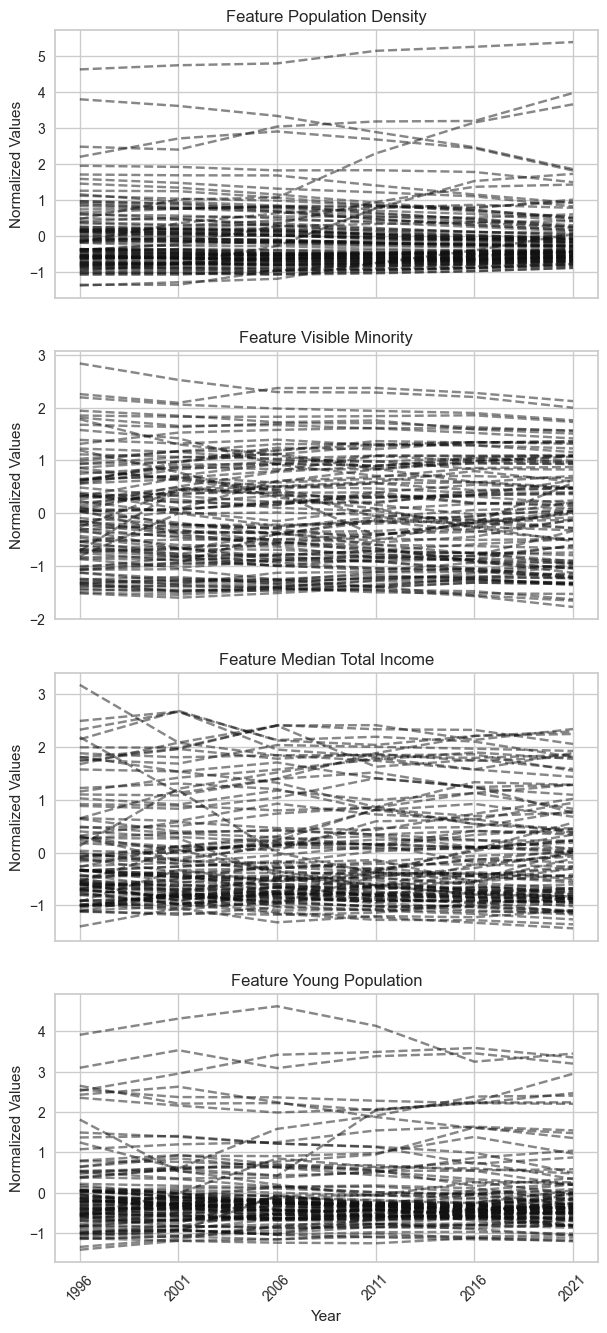

In [ ]:
from tscluster.tsplot import tsplot
fig, ax = tsplot.plot(X=temporal_data_scaled, label_dict=label_dict,figsize=(7,16),
                      ylabel = 'Normalized Values',xlabel='Year')
plt.show()

## Clustering

We first identified the different types of FSAs in Toronto by clustering their historical temporal data, and second, examined atypical FSAs that do not neatly fit into a single type, quantified by the frequency of label changes within each FSA.

To illustrate the distinctive capabilities of 'tscluster', we show both Social Label Analysis (SLA), a common method for neighbourhood change analysis (Delmelle, 2016b), and Bounded Dynamic Clustering (BDC) (for this exercise, we limited the
maximum number of changes to 1. Only a single FSA with the most diverged transition will change its label).

This dual approach allows us to compare SLA with the novel BDC in handling temporal data for neighbourhood change analysis.

### Social Label Analysis (SLA)

Social Label Analysis (SLA) is a traditional method in the analysis of trends and changes in temporal data in neighbourhoods. It allows for the cluster labels of each entity to change over time by clustering each timestamp independently and assuming static cluster centers.

SLA gains insight into the evolution of a given neighbourhood by analyzing changes in its cluster labels over time, which reveal possible transitions between different types of neighbourhoods.

#### Using Elbow method to determine the number of clusters

The first critical problem for clustering algorithms that require a pre-defined number of clusters is deciding the optimal number of clusters $K$. For this exercise, we used the 'Elbow method with Sum of Squares' in the `yellowbrick` package. This method applies K-means clustering with a range of $K$ values and identifies the $K$ value where the sum of squared errors exhibits the maximum curvature.

To simulate the setting of SLA, we also need to breaking the Numpy array `temporal_data_scaled` that contains the normalized time series of each FSA in four features into a Numpy array of individual timestamp data with dimension $(T \times N, F)$.

In [ ]:
#breaking time series data into pointwise data
timestamp_data = temporal_data_scaled.reshape(96*6,4)
timestamp_data.shape

(576, 4)

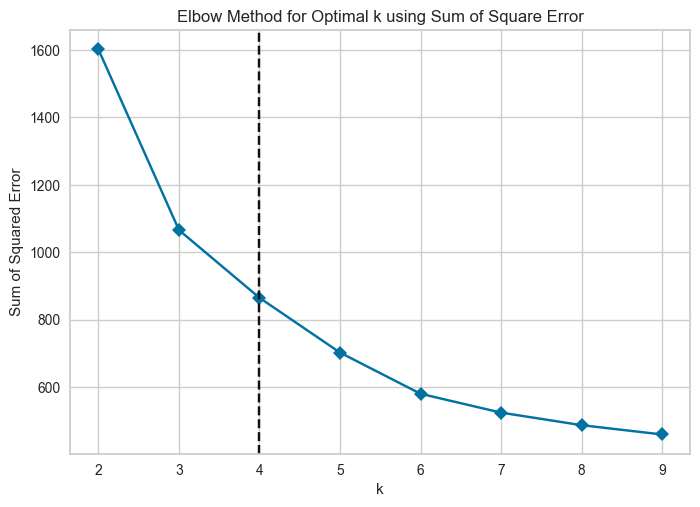

In [ ]:
# we will use the elbow method to determine the optimal number of clusters
from sympy import false
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2,10),timings=False, ax=plt.gca())
visualizer.fit(timestamp_data)       # Fit data to visualizer
plt.title('Elbow Method for Optimal k using Sum of Square Error')
plt.xlabel('k')
plt.ylabel('Sum of Squared Error')
plt.show()

The optimal number for $K$ will be 4 in this case.

#### SLA in 'tscluster'
There are two approaches in 'tscluster' for Sequence Label Analysis (SLA):

- `TSGlobalKmeans`: This provides the traditional SLA approach, using K-means clustering from scikit-learn with timestamp entities, and assigns the labels of each timestamp back to the original temporal data of each FSA.

- `OptTSCluster`: This is a novel Mixed Linear Integer Programming approach, using constrained programming techniques to allow cluster label changes across time while keeping clusters static over time. This approach also guarantees global optimality and reproducibility compared to the traditional K-means approach.

In the notebook, we will demonstrate `TSGlobalKmeans` and reveals potential problem in this tranditional approach due to the lack of global optimality and reproducibility. Appendix 1 shows the same appoarch with `OptTSCluster`, which solves this problem due to global optimality.

In [ ]:
# Using TSGlobalKmeans
from tscluster.tskmeans import TSGlobalKmeans
# initialize the SLA clustering method with the number of cluster = 4
sla = TSGlobalKmeans(n_clusters=4, random_state=4)
# clustering the normalized temporal data with SLA
sla.fit(temporal_data_scaled, label_dict=label_dict)
# print the number of entities that show cluster label changes
print(f"total number of cluster changes is: {sla.n_changes_}")

total number of cluster changes is: 37


**Note:** Since traditional K-means clustering is sensitive to initialization and does not guarantee reproducibility, the clustering results may differ across different software versions and settings.

We can also obtain the cluster labels of each FSA

In [ ]:
cluster_label_sla = sla.labels_
# the cluster labels for the first 5 entities
cluster_label_sla[:5]

array([[1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1]], dtype=int32)

Each FSA has 6 cluster labels, each representing the cluster label of that FSA at the current timestamp (i.e., year) in the temporal data spanning from 1996 to 2021. We also identified the FSAs that exhibit changes in cluster labels over time.

In [ ]:
#the cluster label of first 5 FSA that exhibit cluster label changes
cluster_label_sla[[label_dict['N'].index(i) for i in sla.get_dynamic_entities()[0]]][:5]

array([[3, 0, 3, 0, 0, 0],
       [1, 0, 1, 1, 1, 1],
       [3, 2, 3, 3, 3, 3],
       [0, 0, 0, 3, 0, 0],
       [2, 2, 0, 3, 3, 3]], dtype=int32)

In [ ]:
# the FSA code of first 5 FSA that exhibit cluster label changes
sla.get_dynamic_entities()[0][:5]

['M3B', 'M9R', 'M4S', 'M8Y', 'M6R']

As indicated above, these FSAs has more than one cluster label over time, which suggests changes in cluster labels for these FSAs.

### Bounded Dynamic Clustering (BDC)

Unlike SLA, the novel Bounded Dynamic Clustering (BDC) is only available in `OptTSCluster` under the Mixed Integer Linear Programming (MILP) formulation.

 For this exercise, we set the maximum number of allowable assignment changes parameter (`n_allow_assignment_change`) to 1 to identify the FSAs that exhibit the most divergent changes for atypical change analysis. To mantain consistance as previous SLA, the number of cluster in BDC $K$ is 4.

**Note:** Depending on your computational resources, the BDC for this temporal dataset has a longer runtime compared to previous SLA. It also requires a valid license for Gurobi to utilize the Gurobi MILP solver within 'tscluster'.

In [ ]:
#import the OptTSCluster class from tscluster.opttscluster
from tscluster.opttscluster import OptTSCluster
# initialize the OptTSCluster with the number of clusters = 4 and select BDC (z1c1) as the clustering method
bdc = OptTSCluster(
    k=4,
    scheme='z1c1', # dynamic centers, dynamic assignment
    n_allow_assignment_change=1, # set number of changes to allow as 1
    random_state=4,
    warm_start=False # warm start is not used
)
# clustering the normalized temporal data with BDC
bdc.fit(temporal_data_scaled)

Obj val: [3.8185369]

Total time is 3773.44secs



If the `label_dict` was not provided when initilizing the `OptTSCluster` object, the label of entities and features will be index instead of actual names

In [ ]:
# label_dict was not defined when initilizating the OptTSCluster object for BDC
bdc.label_dict_['T'][:5], bdc.label_dict_['N'][:5], bdc.label_dict_['F'][:5]

([0, 1, 2, 3, 4], [0, 1, 2, 3, 4], [0, 1, 2, 3])

In [ ]:
# label_dict was defined when initilizating the GlobalKMeans object for SLA
sla.label_dict_['T'][:5], sla.label_dict_['N'][:5], sla.label_dict_['F'][:5]

(['1996', '2001', '2006', '2011', '2016'],
 ['M1B', 'M1C', 'M1E', 'M1G', 'M1H'],
 ['Population Density',
  'Visible Minority',
  'Median Total Income',
  'Young Population'])

similiar to SLA, we can obtain the cluster label from the clustering result using BDC

In [ ]:
cluster_label_bdc = bdc.labels_
# the cluster labels for the first 5 entities
cluster_label_bdc[:5]

array([[2, 2, 2, 2, 2, 2],
       [0, 0, 0, 0, 0, 0],
       [2, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2, 2]])

And the FSA that has more than one cluster label (i.e. changed cluster)

In [ ]:
#FSAs that exhibit cluster label changes
cluster_label_bdc[bdc.get_dynamic_entities()[0]]

array([[0, 0, 0, 3, 3, 3]])

In [ ]:
[label_dict['N'][bdc.get_dynamic_entities()[0][i]]
 for i in range(len(bdc.get_dynamic_entities()[0]))]

['M5E']

Since we bounded the maximum number of allowed changes to 1, there is only one FSA that exhibited a change in its cluster label, and this FSA is 'M5E'

## Interpreting
To identify different types of clusters, we can either use the mean of each feature across timestamps within each cluster to interpret the clusters' characteristics, which is a common approach in neighborhood change analysis. Or use the cluster centers from the clustering result as the defining characteristics. Since the cluster centers in BDC is dynamic over time, it represents a temporal trend of each feature, instead of static points in SLA.

To interpret the cluster label change and identifying FSA with most diverged change, we can utilize the `tsplot` module within 'tscluster' to visualize the cluster results (e.g., cluster centers and labels) as a group of univariate time series plots for each of the four features. This approach helps validate whether FSAs exhibiting changes in cluster labels transition from one temporal trend to another in their original time series.

### Clustering result using SLA

#### Cluster definition

Using the mean of each feature across timestamps within the same cluster from the clustering result of SLA, we constructed a heatmap with the value of four feature in each cluster.

In [ ]:
def plot_cluster_heatmap(X: np.ndarray,
                         cluster_result: OptTSCluster|TSGlobalKmeans|KMeans,
                         n_clusters:int,
                         cluster_labels: List[str]|None = None,
                         label_dict: dict|None = None,
                         figsize: tuple = (10, 7)) -> plt.Figure:
    """
    Plot the cluster heatmap for the temporal data based on the cluster result.

    Parameters
    ----------
    temporal_data : np.ndarray
        The temporal data with shape (n_timesteps, n_samples, n_features).
    cluster_result : OptTSCluster|TSGlobalKmeans|KMeans
        The cluster result from three clustering method of 'tscluster'
    n_clusters : int
        The number of clusters in the cluster result.
    cluster_labels : List[str], optional
        The cluster labels, by default None.
        If None, the cluster labels will be 'Cluster 1', 'Cluster 2', ...
    label_dict : dict, optional
        The label dictionary of the temporal data, by default None
        If None, the label dictionary of the cluster result will be used.

    figsize : tuple, optional
        The figure size of the heatmap, by default (10, 7)

    Returns
    -------
    plt.Figure
        The heatmap figure.
    """
    if label_dict is None:
        label_dict = cluster_result.label_dict_

    z_score_matrix = [[[] for _ in range(X.shape[2])]
                      for _ in range(n_clusters)]
    for fsa in range(X.shape[1]):
        current_fsa = cluster_result.labels_[fsa]
        for year in range(X.shape[0]):
            for feature in range(X.shape[2]):
                z_score_matrix[current_fsa[year]][feature].append(X[year,fsa,feature])
    z_score_matrix = np.array(z_score_matrix, dtype=object).T
    z_score_matrix = np.array([[np.mean(z_score_matrix[feature][cluster])
                                for cluster in range(n_clusters)]
                               for feature in range(X.shape[2])])
    result = pd.DataFrame(z_score_matrix, index=label_dict['F'])
    result = result.astype(float)
    if cluster_labels is not None:
        result.columns = cluster_labels
    else:
        result.columns = ['Cluster ' + str(i+1) for i in range(cluster_result.n_clusters)]

    plt.figure(figsize=figsize)
    fig = sns.heatmap(result, cmap='coolwarm', annot=True, fmt=".2f")
    return plt.gcf()

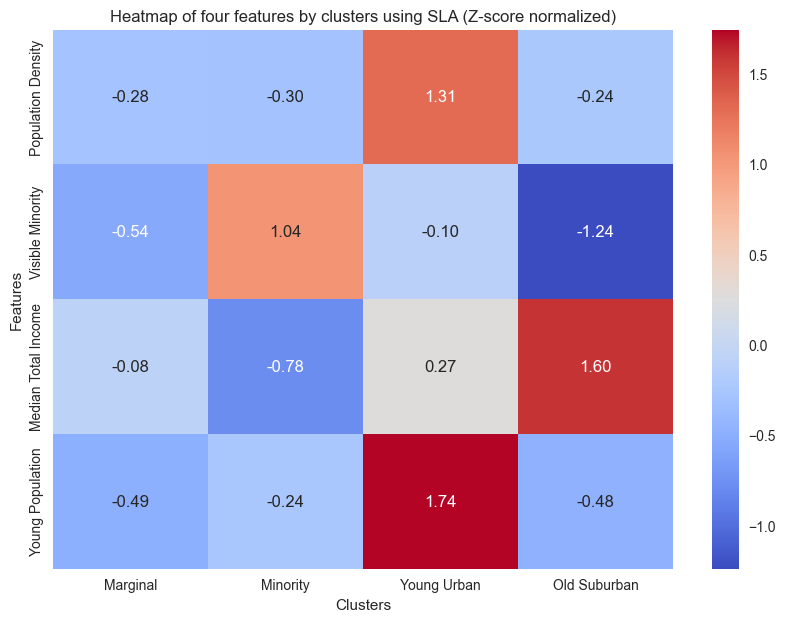

In [ ]:
fig = plot_cluster_heatmap(X = temporal_data_scaled,
                           cluster_result=sla,
                           n_clusters=4,
                           cluster_labels=['Marginal','Minority','Young Urban','Old Suburban'])
                           # assign the cluster labels
plt.title('Heatmap of four features by clusters using SLA (Z-score normalized)')
plt.xlabel('Clusters')
plt.ylabel('Features')
plt.show()

Using the heatmap above, we can obtain four different types of FSA:

- Cluster 1 Marginal: This type of FSA exhibits the lowest values across all four features and is located within Toronto's suburbs, lacking clear geographical characteristics.

- Cluster 2 Visual Minority: This type of suburban FSA has the highest percentage of visual minorities with the lowest median income. This cluster is situated in the peripheral regions of Toronto's suburbs

- Cluster 3 Young Urban: Concentrated in the central city, this type of FSA has the highest average population density and exhibits an exceptionally high youth population.

- Cluster 4 Old Suburban: Predominantly comprising suburban FSAs concentrated within the southeast corner and midtown of Toronto with the lowest average percentage of young adults, while boasting the high average median total income.

#### Atypical change analysis

We visulized all FSAs that exhibit change in cluster labels using the `tsplot` module within 'tscluster'. The `tsplot.plot()` function visualizes the time series of each feature within the selected FSA.

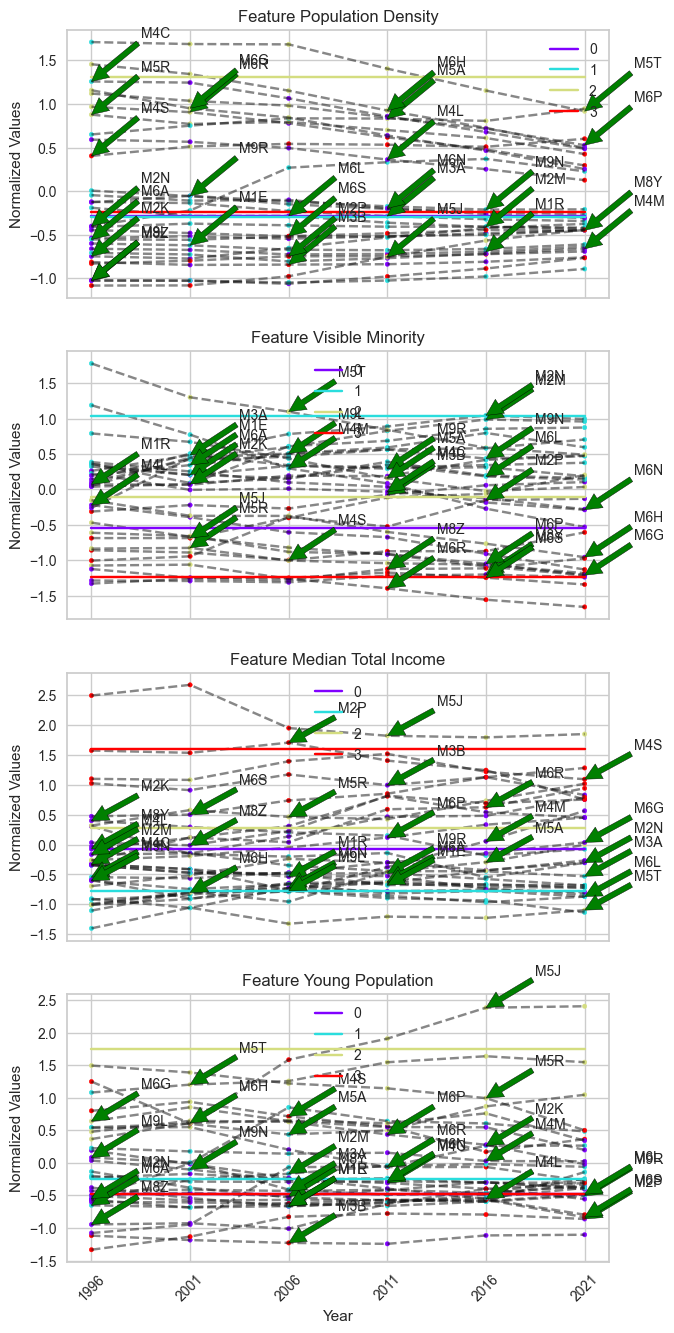

In [ ]:
fig, ax = tsplot.plot(
    X=temporal_data_scaled, # the normalized temporal data
    cluster_centers=sla.cluster_centers_, # the cluster centers
    labels=sla.labels_, label_dict=label_dict, # the cluster labels and the label dictionary
    entity_idx=[label_dict['N'].index(i) for i in sla.get_dynamic_entities()[0]], # the entities that exhibit cluster label changes
    show_all_entities=False,figsize=(7,16), annot_fontsize = 10,
    xlabel='Year',ylabel='Normalized Values'
    ) # show only the entities that exhibit cluster label changes

It is challenging to distinguish which FSAs contain the most divergent changes in the plot above, as there are too many FSAs changing clusters in this unbounded scheme. Instead, we can use the frequency of cluster label changes to identify the FSAs with the most divergent changes from one temporal trend to another. In this case, the FSA with the highest frequency of label changes will be considered as the sample that exhibits the most divergent change in temporal trend.

The FSA that exhibits the most frequent cluster label changes can be directly obtained using the `get_dynamic_entities()` function in 'tscluster'. It returns a tuple consisting of a list of labels of samples that exhibit more than 0 cluster label changes and the number of cluster labels each sample exhibited, sorted in descending order.

In [ ]:
# The label of the top 5 FSA entites that exhibit the most frequent cluster label changes
sla.get_dynamic_entities()[0][:5]

['M3B', 'M9R', 'M4S', 'M8Y', 'M6R']

In [ ]:
# The number of cluster label changes for the top 5 FSA
sla.get_dynamic_entities()[1][:5]

[3, 2, 2, 2, 2]

In the example provided, among the top 5 FSAs that exhibit the most frequent cluster label changes, the FSA 'M3B' exhibits 3 changes, while the rest of the FSAs exhibit 2 changes each. Therefore, 'M3B' will be considered as the FSA with the most divergent change based on our definition.

To check the cluster label of 'M3B', we could utilize the `labels_` entity in the clustering result

In [ ]:
sla.labels_[label_dict['N'].index('M3B')] + 1
# since python index start from 0, we add 1 to match with the index we used in cluster definition.

array([4, 1, 4, 1, 1, 1], dtype=int32)

Based on the previous cluster definitions and cluster labels, we observed that 'M3B' transitioned from 'Old Suburban' to 'Marginal'. To validate this atypical change, we used the `tsplot.plot()` function to visualize the time series of 'M3B' for each feature.

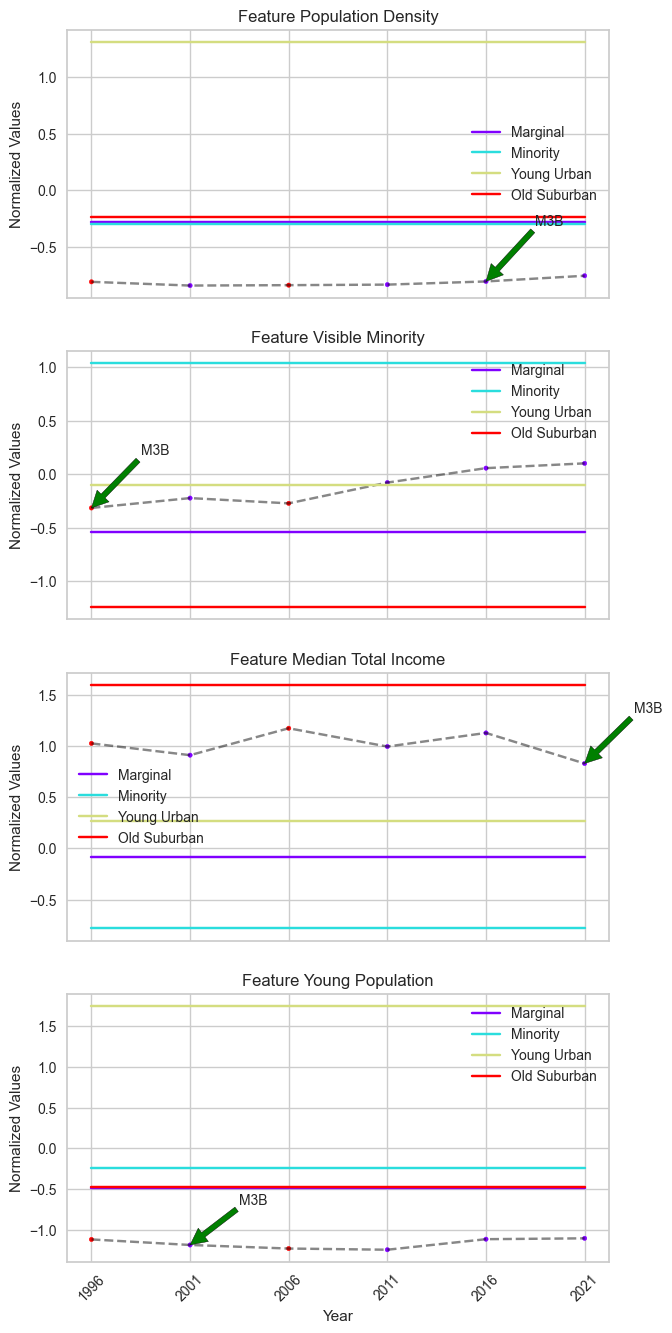

In [ ]:
fig, ax = tsplot.plot(
    X=temporal_data_scaled, # the normalized temporal data
    cluster_centers=sla.cluster_centers_, # the cluster centers
    labels=sla.labels_, label_dict=label_dict, # the cluster labels and the label dictionary
    entity_idx= [label_dict['N'].index('M3B')], # show 'M3B' only
    show_all_entities=False,figsize=(7,16), annot_fontsize = 10,
    xlabel='Year',ylabel='Normalized Values',
    cluster_labels=['Marginal','Minority','Young Urban','Old Suburban']) # the cluster labels (i.e. four type of FSA we defined)

M3B’s features, particularly 'Median Total Income', do not show pronounced changes, although the cluster centers suggest a significant difference.

To uncover the reason behind this discrepancy, we visualized the distribution of timestamps within 'Marginal' and 'Old Suburban' based on their values in 'Median Total Income'.

In [ ]:
def scatter(X: np.ndarray, cluster1: int|str, cluster2: int|str, feature:str,
             cluster_result: OptTSCluster|TSGlobalKmeans|KMeans,
             cluster_labels: List[str]|None = None,
             entity_idx: List[str]|List[int]|None = None,
             label_dict: dict|None = None,
             figsize: tuple = (10, 7)) -> plt.Figure:
    """
    Visualizing the distribution of timestamps within two clusters based on a seletecd feature.

    Parameters
    ----------
    X : np.ndarray
        The temporal data with shape (n_timesteps, n_samples, n_features).
    cluster1 : int|str
        The cluster number of the first cluster.
        If cluster_labels is not None, cluster1 can also be a string within cluster label.
    cluster2 : int|str
        The cluster number of the second cluster.
        If cluster_labels is not None, cluster2 can also be a string within cluster label.
    feature : str
        The feature name.
    cluster_result : OptTSCluster|TSGlobalKmeans|KMeans
        The cluster result from three clustering method of 'tscluster'
    cluster_labels : List[str], optional
        The cluster labels, by default None.
        If None, the cluster labels will be 'Cluster 1', 'Cluster 2', ...
        If not None, the cluster labels will be shown in the legend.
    entity_idx : List[str]|List[int], optional
        The entities to show in the scatter plot, by default None.
        If None, no entities will be shown.
    label_dict : dict, optional
        The label dictionary of the temporal data, by default None
        If None, the label dictionary of the cluster result will be used.
    figsize : tuple, optional
        The figure size of the heatmap, by default (10, 7)

    Returns
    -------
    plt.Figure
        The scatter plot figure.
    """
    if label_dict is None:
        label_dict = cluster_result.label_dict_

    if not (isinstance(cluster1, str) or isinstance(cluster2, str)):
        if cluster1 >= cluster_result.n_clusters or cluster2 >= cluster_result.n_clusters:
            raise ValueError('The cluster number is out of range.')
    else:
        if cluster_labels is None:
            raise ValueError('cluster1 and cluster2 is String but the cluster labels are not provided.')
        else:
            if cluster1 in cluster_labels:
                cluster1 = cluster_labels.index(cluster1)
            else:
                raise ValueError('The cluster1 label is not in the cluster labels.')
            if cluster2 in cluster_labels:
                cluster2 = cluster_labels.index(cluster2)
            else:
                raise ValueError('The cluster2 label is not in the cluster labels.')

    if feature not in label_dict['F']:
        raise ValueError('The feature is not in the feature list.')

    else:
        if entity_idx is None:
            entity_idx = []
        if isinstance(entity_idx[0], str):
            entity_idx = [label_dict['N'].index(i) for i in entity_idx]
        cluster1_lst = []
        cluster2_lst = []
        sample_lst = []
        plt.figure(figsize=figsize)
        for fsa in range(X.shape[1]):
            current_fsa = cluster_result.labels_[fsa]
            for year in range(X.shape[0]):
                if current_fsa[year] == cluster1:
                    cluster1_lst.append(X[year,fsa,label_dict['F'].index(feature)])
                elif current_fsa[year] == cluster2:
                    cluster2_lst.append(X[year,fsa,label_dict['F'].index(feature)])
                if fsa in entity_idx:
                    sample_lst.append(X[year,fsa,label_dict['F'].index(feature)])
        if cluster_labels is not None:
            cluster1 = cluster_labels[cluster1]
            cluster2 = cluster_labels[cluster2]
        else:
            cluster1 = 'Cluster ' + str(cluster1+1)
            cluster2 = 'Cluster ' + str(cluster2+1)
        plt.scatter( cluster1_lst, np.ones(len(cluster1_lst)), color='red',
                    label=cluster1,alpha=0.5)
        plt.scatter( cluster2_lst, np.zeros(len(cluster2_lst)), color='blue',
                    label=cluster2,alpha=0.5)
        plt.scatter(sample_lst, [0.5 for _ in range(len(sample_lst))],
                    color='black', marker='x',
                    label=label_dict['N'][entity_idx[0]], s=100)
        plt.xlabel(feature)
        plt.yticks([0,0.5,1], labels=[cluster2, 'Selected Entity', cluster1])

        plt.legend(loc='upper right')
    return plt.gcf()

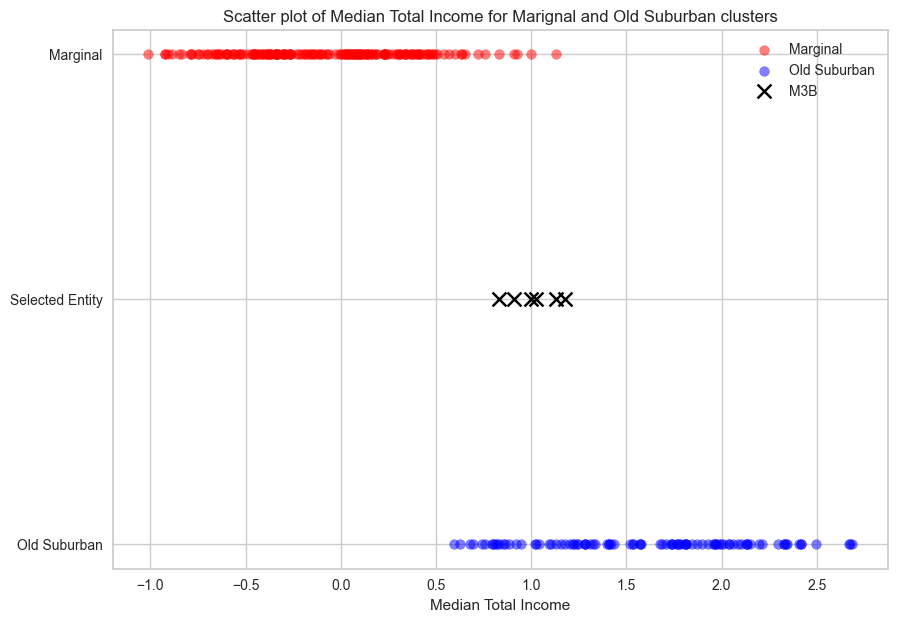

In [ ]:
fig = scatter(X = temporal_data_scaled,
              cluster1 = 'Marginal',cluster2 = 'Old Suburban',
              feature='Median Total Income',
              cluster_result=sla,
              cluster_labels=['Marginal','Minority','Young Urban','Old Suburban'],
              entity_idx=['M3B'])
plt.title('Scatter plot of Median Total Income for Marignal and Old Suburban clusters')
plt.legend()
plt.show()

The red encoded scatter represents timestamps within the 'Marginal' cluster, which exhibit a lower median total income (x-axis) compared to the timestamps within the 'Old Suburban' cluster (blue encoded scatter). However, 'M3B' (marked as a cross) is located on the boundary between these two clusters, making it sensitive to statistical noise when clustering without global optimality (i.e., SLA).

Without incorporating limitation on the maximum allowable label changes, entities like M3B risk transitioning repeatedly between cluster boundaries without meaningful data changes.

### Clustering result using BDC

#### Cluster definition
To maintain consistency, we used the same method as Sequence Label Analysis (SLA), which involves calculating the mean of each feature across timestamps, to define each cluster in the result of Bounded Dynamic Clustering (BDC).

**Note: The order of cluster might not be consistent across methods due to initialization. Please validate the mean of each feature in the heatmap with the detailed cluster definitions provided in the SLA section to determine the correct order.**

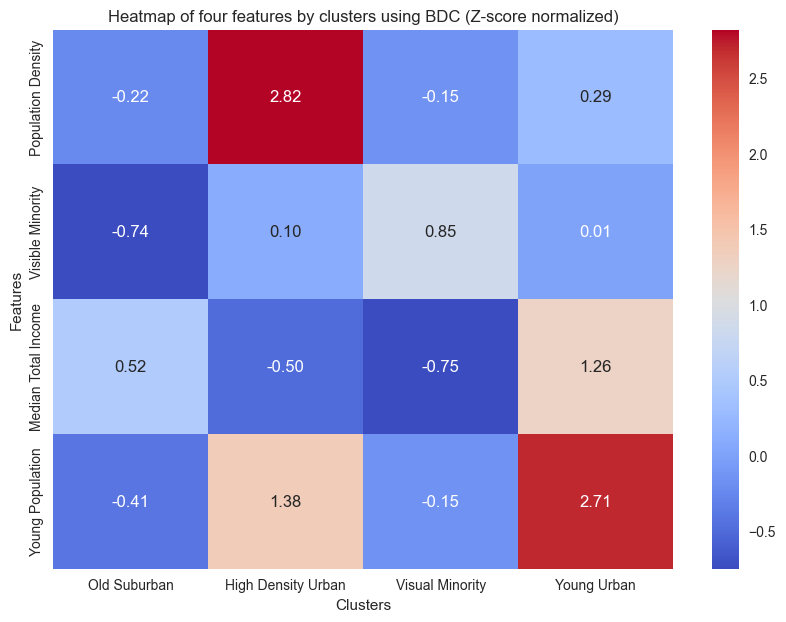

In [ ]:
fig = plot_cluster_heatmap(X = temporal_data_scaled,
                           cluster_result=bdc,
                           n_clusters=4,
                           cluster_labels=['Old Suburban','High Density Urban','Visual Minority','Young Urban'],
                           # assign the cluster labels
                           label_dict = label_dict)
plt.title('Heatmap of four features by clusters using BDC (Z-score normalized)')
plt.xlabel('Clusters')
plt.ylabel('Features')
plt.show()

Compared to the result of the SLA, the 'Young Urban' exhibits a significantly lower population density. An additional cluster named 'High Density Urban' has a high population density in central Toronto.

#### Atypical change analysis

The only FSA that exhibits change in cluster labels is 'M5E'. We checked the cluster label of 'M5E'

In [ ]:
#cluster label of M5E
cluster_label_bdc[label_dict['N'].index('M5E')] + 1
# since python index start from 0, we add 1 to match with the index we used in cluster definition.

array([1, 1, 1, 4, 4, 4])

M5E spans King Street to Lake Ontario and west from Yonge to Jarvis Street, incorporating Waterfront Toronto, a major redevelopment project. The 2000 Toronto Waterfront Revitalization Initiative transformed the lakeshore into high-density condos, likely influencing population density trends in M5E from 2000 onwards. This initiative also likely impacted the distribution of young professionals, who have a high demand in the condominium market .

In clustering results,  M5E transitioned from 'Old Suburban' to 'Young Urban' in 2006. Among the four socioeconomic features we used in clustering, this transition is captured by changes in 'young population' and `population density.'

We can validate this change with its time series in these two features.

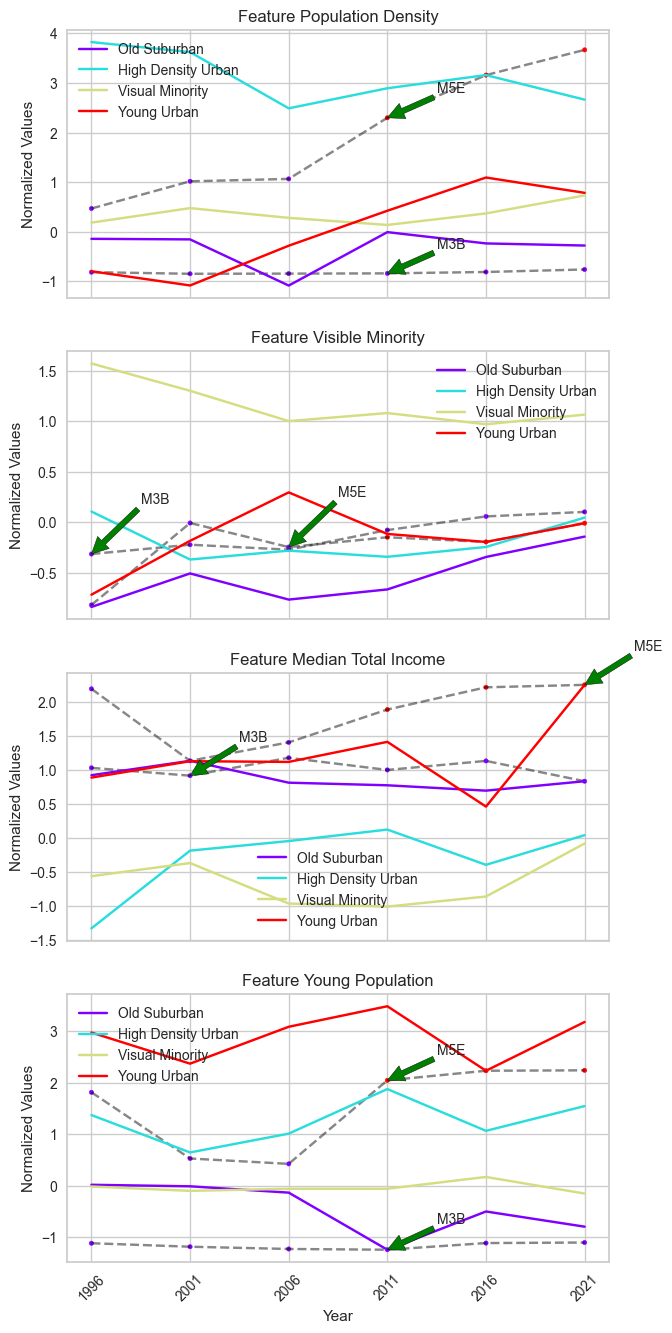

In [ ]:
tsplot.plot(
    X=temporal_data_scaled, # the normalized temporal data
    cluster_centers=bdc.cluster_centers_, # the cluster centers
    labels=bdc.labels_, label_dict=label_dict, # the cluster labels and the label dictionary
    entity_idx= [label_dict['N'].index('M5E'), label_dict['N'].index('M3B')], # show 'M5E' and 'M3B' only
    show_all_entities=False,figsize=(7,16), annot_fontsize = 10,
    xlabel='Year',ylabel='Normalized Values',
    cluster_labels=['Old Suburban','High Density Urban','Visual Minority','Young Urban']) # the cluster labels (i.e. four type of FSA we defined)
plt.show()

We compared the time series of 'M3B' with 'M5E' across the four features. In 'M5E', significant increases in both features are observed from 2006 onward, coinciding with its transition from 'Old Suburban' to 'Young Urban' under BDC. From the scatter plot below, we observed a clear boundary in 'M5E' timestamps indicating the transition from one cluster to another.

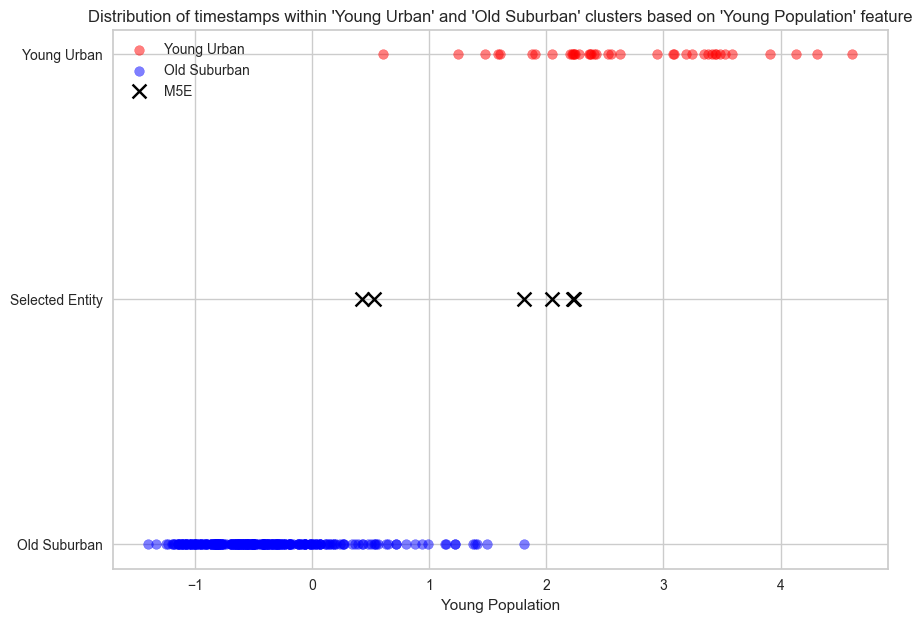

In [ ]:
fig = scatter(X = temporal_data_scaled,
              cluster1 = 'Young Urban',cluster2 = 'Old Suburban',
              feature='Young Population',
              cluster_result=bdc,
              cluster_labels=['Old Suburban','High Density Urban','Visual Minority','Young Urban'],
              entity_idx=['M5E'],
              label_dict = label_dict)
plt.title("Distribution of timestamps within 'Young Urban' and 'Old Suburban' clusters based on 'Young Population' feature")
plt.legend()
plt.show()

 It is worth noting that M5E is located in the Toronto Urban Area, which contradicts the geographical definition of `Old Suburban', one of the neighbourhood types it belongs. Since geographical locations are not one of the four features we used in clustering, the geographical definition of each FSA type is based on a post-hoc evaluation of FSAs within each cluster. Therefore, only differences in the four features should be considered when we analyzed cluster label changes, and M5E correctly reflects these differences.


In short, BDC, a novel temporal clustering method in `tscluster', demonstrates significant advantages over SLA in identifying atypical FSAs in this case study. BDC successfully captures the most divergent transition of M5E, reflecting the real-world impact of the Toronto Waterfront Revitalization Initiative, while avoiding misidentifying FSAs such as M3B that are susceptible to statistical noise. Moreover, BDC retains the ability to summarize cluster definitions similar to SLA.

## Appendix 1: Clustering result using SLA with global optimality

In [ ]:
# Using OptTsCluster
from tscluster.opttscluster import OptTSCluster
# initialize the OptTSCluster with the number of clusters = 4
sla_opt = OptTSCluster(
    k=4, # 4 cluster
    scheme='z0c1', # static center, dynamic assignment
    n_allow_assignment_change=None, # unbounded number of allowed assignment changes
    random_state=42,
    warm_start=False # warm start is not used
)
# clustering the normalized temporal data with SLA
sla_opt.fit(temporal_data_scaled)

Obj val: [3.95967354]

Total time is 103.24secs



### Cluster definition

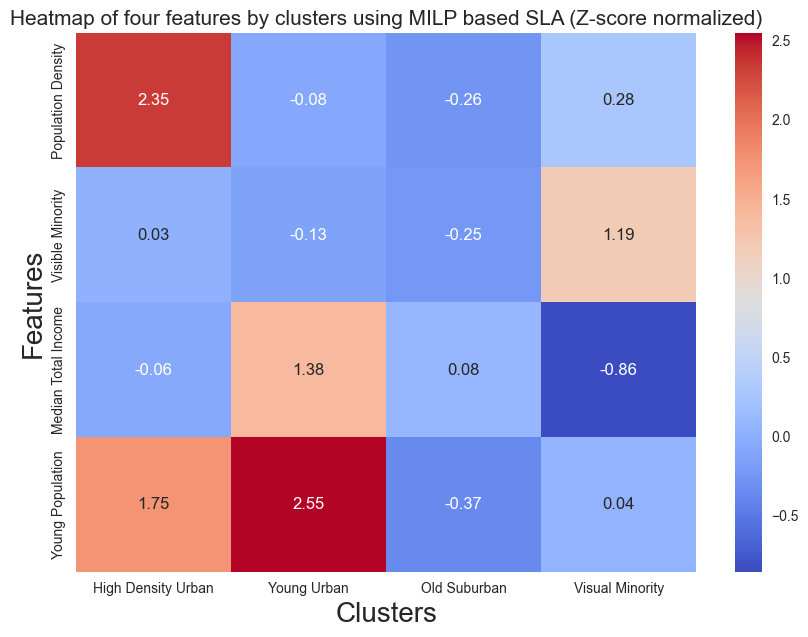

In [ ]:
fig = plot_cluster_heatmap(X = temporal_data_scaled,
                           cluster_result=sla_opt,
                           n_clusters=4,
                           cluster_labels=['High Density Urban','Young Urban',
                                           'Old Suburban','Visual Minority'],
                           # assign the cluster labels
                           label_dict = label_dict)
plt.title('Heatmap of four features by clusters using MILP based SLA (Z-score normalized)',fontsize=15)
plt.show()

The clustering definition from SLA with global optimality shows a similiar result as BDC, which includes 'High Density Urban' and elimates the 'Marginal Cluster'.

### Atypical change analysis

Top 5 FSAs with the most frequent label change

In [ ]:
sla_opt.labels_[sla_opt.get_dynamic_entities()[0]][:5]

array([[2, 2, 3, 2, 3, 2],
       [1, 0, 3, 1, 0, 0],
       [3, 0, 3, 2, 2, 2],
       [0, 0, 3, 2, 2, 3],
       [2, 3, 2, 2, 2, 2]])

In [ ]:
[label_dict['N'][i][:5] for i in sla_opt.get_dynamic_entities()[0]][:5]

['M2M', 'M5E', 'M6J', 'M6H', 'M9W']

number of changes each FSA has

In [ ]:
sla_opt.get_dynamic_entities()[1][:5]

[4, 4, 3, 3, 2]

Note that SLA with global optimality is able to identify 'M5E' as one of the FSAs with the most divergent change. We also visualized another FSA with the most frequent number of changes: 'M2M'.

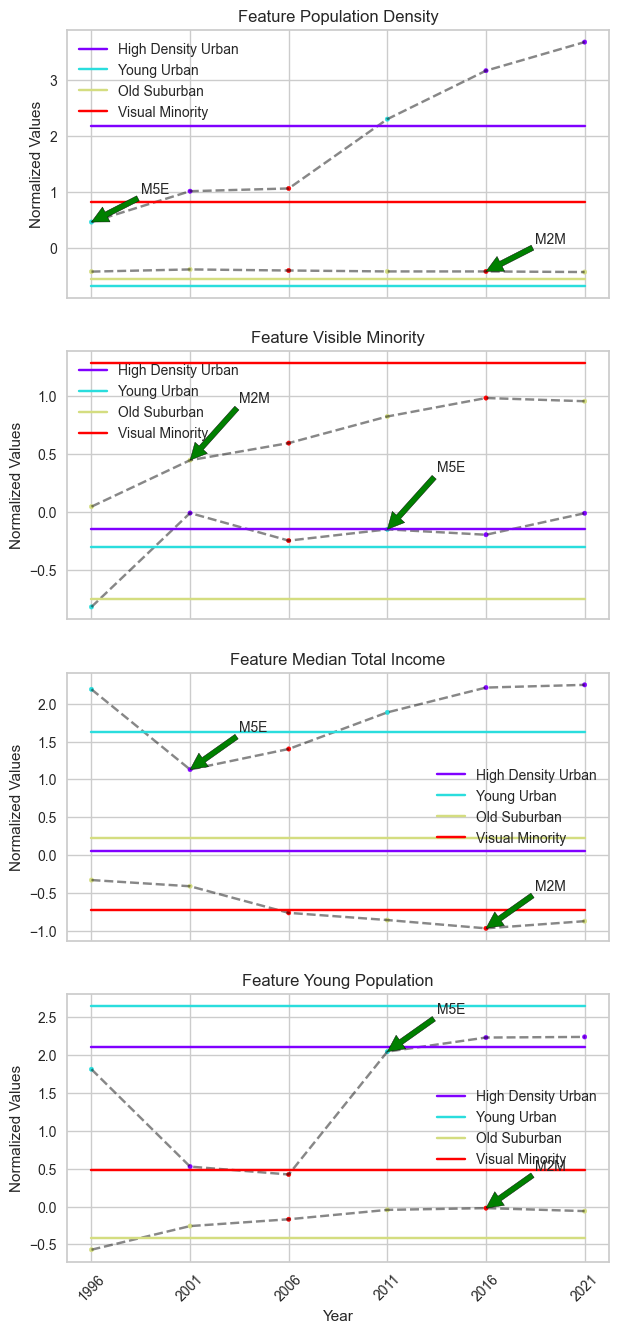

In [ ]:
tsplot.plot(
    X=temporal_data_scaled, # the normalized temporal data
    cluster_centers=sla_opt.cluster_centers_, # the cluster centers
    labels=sla_opt.labels_, label_dict=label_dict, # the cluster labels and the label dictionary
    entity_idx= sla_opt.get_dynamic_entities()[0][:2], # show the entities that exhibit cluster label changes
    show_all_entities=False,figsize=(7,16), annot_fontsize = 10,
    cluster_labels=['High Density Urban','Young Urban',
                    'Old Suburban','Visual Minority'], # the cluster labels (i.e. four type of FSA we defined)
    xlabel='Year',ylabel='Normalized Values') # the cluster labels (i.e. four type of FSA we defined)
plt.show()